### Лабораторная работа №3. VAE

Разработать модель вариационного автокодировщика.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import typing as t
from tensorflow.python.data.ops.dataset_ops import BatchDataset
from tensorflow.python.keras import Model
from tensorflow.python.keras.optimizers import Optimizer

In [170]:
params: dict[str, t.Any] = {
    'encoder_layers': [128],
    'decoder_layers': [128],
    'digit_classification_layers': [128],
    'activation': 'sigmoid',
    'decoder_std': 0.5,
    'z_dim': 10,
    'digit_classification_weight': 10.0,
    'epochs': 20,
    'batch_size': 100,
    'learning_rate': 0.001
}

### Модель VAE

In [ ]:
class VAE(Model):
    """
    Вариационный автоэнкодер для генерации рукописных цифр MNIST.
    
    Состоит из:
    1. Энкодера - кодирует изображение в латентное пространство
    2. Декодера - восстанавливает изображение из латентного представления
    3. Классификатора - предсказывает цифру на входном изображении
    """
    def __init__(self, params: dict[str, t.Any]):
        """."""

        super(VAE, self).__init__()
        self.params = params

        encoder_layers = [
            layers.Dense(u, activation=params['activation']) 
            for u in params['encoder_layers']
        ]
        self.encoder = tf.keras.Sequential(encoder_layers)
        self.mu_layer = layers.Dense(params['z_dim'])
        self.log_var_layer = layers.Dense(params['z_dim'])

        classifier_layers = [
            layers.Dense(u, activation=params['activation']) 
            for u in params['digit_classification_layers']
        ]
        self.classifier = tf.keras.Sequential(classifier_layers + [layers.Dense(10)])
    
        decoder_layers = [
            layers.Dense(u, activation=params['activation']) 
            for u in params['decoder_layers']
        ]
        self.decoder = tf.keras.Sequential(decoder_layers + [layers.Dense(784, activation='sigmoid')])

    def encode(self, x: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
        """Кодирует входные данные в параметры нормального распределения."""
        h = self.encoder(x)
        return self.mu_layer(h), self.log_var_layer(h)
    
    def reparameterize(self, mu: tf.Tensor, log_var: tf.Tensor) -> tf.Tensor:
        """РепараметризациЯ для семплирования из распределения."""
        std = tf.exp(0.5 * log_var)
        eps = tf.random.normal(shape=mu.shape)
        return mu + eps * std
    
    def decode(self, z: tf.Tensor, digit_prob: tf.Tensor) -> tf.Tensor:
        """Декодирует латентное представление в изображение."""
        inputs = tf.concat([z, digit_prob], axis=1)
        return self.decoder(inputs)
    
    def classify(self, x: tf.Tensor) -> tf.Tensor:
        """Классифицирует цифру на входном изображении."""
        return self.classifier(x)

    def call(self, x: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
        """Полный проход данных через модель."""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        digit_logits = self.classify(x)
        digit_prob = tf.nn.softmax(digit_logits)
        reconstructed = self.decode(z, digit_prob)
        return reconstructed, mu, log_var, digit_logits

    def generate(self, digit: int, z: tf.Tensor | None = None) -> tf.Tensor:
        """Генерирует изображение по заданной цифре и латентному вектору."""
        if z is None:
            z = tf.random.normal((1, self.param['z_dim']))
        digit_one_hot = tf.one_hot([digit], depth=10)
        return self.decode(z, digit_one_hot)

In [172]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .shuffle(buffer_size=params.get('buffer_size', 1024))
    .batch(params['batch_size'])
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset
    .batch(params['batch_size'])
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [173]:
model = VAE(params)
tf.config.run_functions_eagerly(True)
optimizer = tf.keras.optimizers.Adam(params['learning_rate'])

In [174]:
def compute_loss(
        x: tf.Tensor, 
        y: tf.Tensor,
        reconstructed: tf.Tensor,
        mu: tf.Tensor,
        log_var: tf.Tensor,
        digit_logits: tf.Tensor,
) -> tf.Tensor:
    """Вычисляет суммарные потери модели."""
    recon_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(x, reconstructed, from_logits=False),
        axis=-1,
    )

    kl_loss = -0.5 * tf.reduce_sum(
        1 + log_var - tf.square(mu) - tf.exp(log_var),
        axis=-1,
    )

    cls_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, 
            logits=digit_logits
        )
    )

    cls_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=digit_logits)
    ) * params['digit_classification_weight']

    total_loss = tf.reduce_mean(recon_loss + kl_loss)

    return total_loss +  cls_loss

In [175]:
@tf.function
def train_step(
    x: tf.Tensor,
    y: tf.Tensor,
    model: Model,
    optimizer: Optimizer,
    metrics: dict[str, tf.keras.metrics.Metric],
) -> tuple[tf.Tensor, dict[str, float]]:
    """Один шаг обучения модели с расширенными возможностями."""
    with tf.GradientTape() as tape:
        reconstructed, mu, log_var, digit_logits = model(x, training=True)
        total_loss = compute_loss(
            x=x,
            y=y,
            reconstructed=reconstructed,
            mu=mu,
            log_var=log_var,
            digit_logits=digit_logits,
        )
        regularization_loss = tf.reduce_sum(model.losses)
        total_loss += regularization_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    if None in gradients:
        raise ValueError
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    metrics['total_loss'].update_state(total_loss)
    metrics['recon_loss'].update_state(
        tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, reconstructed))
    )
    metrics['kl_loss'].update_state(
        -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    )
    metrics['cls_loss'].update_state(
        tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=y, 
                logits=digit_logits
            )
        )
    )

    return total_loss, metrics

In [176]:
from tqdm import tqdm

In [177]:
def train_model(
    model: Model,
    optimizer: Optimizer,
    train_dataset: BatchDataset,
    params: dict[str, t.Any],
    validation_dataset: BatchDataset | None = None,
) -> tuple[list[float], list[float]]:
    """Полный цикл обучения модели с расширенными возможностями."""
    train_losses = []
    val_losses = []
    metrics = {
        'total_loss': tf.keras.metrics.Mean(),
        'recon_loss': tf.keras.metrics.Mean(),
        'kl_loss': tf.keras.metrics.Mean(),
        'cls_loss': tf.keras.metrics.Mean()
    }

    for epoch in range(params['epochs']):
        epoch_train_loss = tf.keras.metrics.Mean()
        progress_bar = tqdm(
            train_dataset,
            desc=f'Epoch {epoch+1}/{params["epochs"]}',
            unit='batch'
        )

        for x_batch, y_batch in progress_bar:
            x_batch = tf.cast(x_batch, tf.float32)
            y_batch = tf.cast(y_batch, tf.int32)

            loss, metrics = train_step(
                x=x_batch,
                y=y_batch,
                model=model,
                optimizer=optimizer,
                metrics=metrics,
            )

            epoch_train_loss.update_state(loss)
            progress_bar.set_postfix({
                'loss': f'{metrics["total_loss"].result().numpy():.4f}',
                'recon': f'{metrics["recon_loss"].result().numpy():.4f}',
                'kl': f'{metrics["kl_loss"].result().numpy():.4f}',
                'cls': f'{metrics["cls_loss"].result().numpy():.4f}'
            })

        train_losses.append(epoch_train_loss.result().numpy())
        
        if validation_dataset:
            val_loss = validate_model(model, validation_dataset)
            val_losses.append(val_loss.numpy())
            print(f'\nValidation Loss: {val_loss:.4f}')

        print(f'\nEpoch {epoch+1} завершена, средний loss: {train_losses[-1]:.4f}')

    return train_losses, val_losses

def validate_model(
    model: Model,
    validation_dataset: BatchDataset,
) -> tf.Tensor:
    """Оценка модели на валидационном наборе данных"""
    epoch_val_loss = tf.keras.metrics.Mean()
    
    for x_batch, y_batch in validation_dataset:
        x_batch = tf.cast(x_batch, tf.float32)
        y_batch = tf.cast(y_batch, tf.int32)
        
        reconstructed, mu, log_var, digit_logits = model(x_batch, training=False)
        loss = compute_loss(
            x=x_batch,
            y=y_batch,
            reconstructed=reconstructed,
            mu=mu,
            log_var=log_var,
            digit_logits=digit_logits,
        )
        epoch_val_loss.update_state(loss)
        
    return epoch_val_loss.result()

In [178]:
train_losses, val_losses = train_model(
    model=model,
    optimizer=optimizer,
    train_dataset=train_dataset,
    validation_dataset=test_dataset,
    params=params,
)

Epoch 1/20: 100%|██████████| 600/600 [00:50<00:00, 11.93batch/s, loss=33.0292, recon=0.2716, kl=0.0215, cls=0.5656]



Validation Loss: 27.6959

Epoch 1 завершена, средний loss: 33.0292


Epoch 2/20: 100%|██████████| 600/600 [00:51<00:00, 11.58batch/s, loss=29.3447, recon=0.2496, kl=0.0243, cls=0.4140]



Validation Loss: 24.3901

Epoch 2 завершена, средний loss: 25.6601


Epoch 3/20: 100%|██████████| 600/600 [00:51<00:00, 11.71batch/s, loss=27.4761, recon=0.2372, kl=0.0295, cls=0.3464]



Validation Loss: 23.3700

Epoch 3 завершена, средний loss: 23.7391


Epoch 4/20: 100%|██████████| 600/600 [00:52<00:00, 11.47batch/s, loss=26.3493, recon=0.2291, kl=0.0394, cls=0.3046]



Validation Loss: 22.6939

Epoch 4 завершена, средний loss: 22.9686


Epoch 5/20: 100%|██████████| 600/600 [00:53<00:00, 11.18batch/s, loss=25.5808, recon=0.2234, kl=0.0497, cls=0.2745]



Validation Loss: 22.3398

Epoch 5 завершена, средний loss: 22.5069


Epoch 6/20: 100%|██████████| 600/600 [00:50<00:00, 11.96batch/s, loss=25.0181, recon=0.2192, kl=0.0583, cls=0.2511]



Validation Loss: 22.1569

Epoch 6 завершена, средний loss: 22.2041


Epoch 7/20: 100%|██████████| 600/600 [00:50<00:00, 11.97batch/s, loss=24.5833, recon=0.2161, kl=0.0655, cls=0.2322]



Validation Loss: 21.9356

Epoch 7 завершена, средний loss: 21.9747


Epoch 8/20: 100%|██████████| 600/600 [00:52<00:00, 11.50batch/s, loss=24.2293, recon=0.2135, kl=0.0717, cls=0.2164]



Validation Loss: 21.7185

Epoch 8 завершена, средний loss: 21.7512


Epoch 9/20: 100%|██████████| 600/600 [00:50<00:00, 11.78batch/s, loss=23.9284, recon=0.2113, kl=0.0772, cls=0.2028]



Validation Loss: 21.5508

Epoch 9 завершена, средний loss: 21.5214


Epoch 10/20: 100%|██████████| 600/600 [00:55<00:00, 10.83batch/s, loss=23.6641, recon=0.2093, kl=0.0824, cls=0.1910]



Validation Loss: 21.3575

Epoch 10 завершена, средний loss: 21.2852


Epoch 11/20: 100%|██████████| 600/600 [00:54<00:00, 10.98batch/s, loss=23.4278, recon=0.2075, kl=0.0874, cls=0.1806]



Validation Loss: 21.1974

Epoch 11 завершена, средний loss: 21.0646


Epoch 12/20: 100%|██████████| 600/600 [00:55<00:00, 10.84batch/s, loss=23.2150, recon=0.2058, kl=0.0921, cls=0.1713]



Validation Loss: 21.0214

Epoch 12 завершена, средний loss: 20.8745


Epoch 13/20: 100%|██████████| 600/600 [00:54<00:00, 11.06batch/s, loss=23.0225, recon=0.2043, kl=0.0965, cls=0.1630]



Validation Loss: 20.8937

Epoch 13 завершена, средний loss: 20.7125


Epoch 14/20: 100%|██████████| 600/600 [00:53<00:00, 11.15batch/s, loss=22.8471, recon=0.2029, kl=0.1008, cls=0.1554]



Validation Loss: 20.7963

Epoch 14 завершена, средний loss: 20.5668


Epoch 15/20: 100%|██████████| 600/600 [00:50<00:00, 11.94batch/s, loss=22.6867, recon=0.2015, kl=0.1048, cls=0.1485]



Validation Loss: 20.7233

Epoch 15 завершена, средний loss: 20.4417


Epoch 16/20: 100%|██████████| 600/600 [00:52<00:00, 11.45batch/s, loss=22.5409, recon=0.2003, kl=0.1086, cls=0.1423]



Validation Loss: 20.6639

Epoch 16 завершена, средний loss: 20.3529


Epoch 17/20: 100%|██████████| 600/600 [00:51<00:00, 11.76batch/s, loss=22.4055, recon=0.1992, kl=0.1122, cls=0.1365]



Validation Loss: 20.5604

Epoch 17 завершена, средний loss: 20.2386


Epoch 18/20: 100%|██████████| 600/600 [00:51<00:00, 11.71batch/s, loss=22.2804, recon=0.1981, kl=0.1156, cls=0.1311]



Validation Loss: 20.5156

Epoch 18 завершена, средний loss: 20.1539


Epoch 19/20: 100%|██████████| 600/600 [00:50<00:00, 11.90batch/s, loss=22.1653, recon=0.1971, kl=0.1189, cls=0.1262]



Validation Loss: 20.4387

Epoch 19 завершена, средний loss: 20.0928


Epoch 20/20: 100%|██████████| 600/600 [00:51<00:00, 11.76batch/s, loss=22.0579, recon=0.1962, kl=0.1220, cls=0.1216]



Validation Loss: 20.4167

Epoch 20 завершена, средний loss: 20.0188


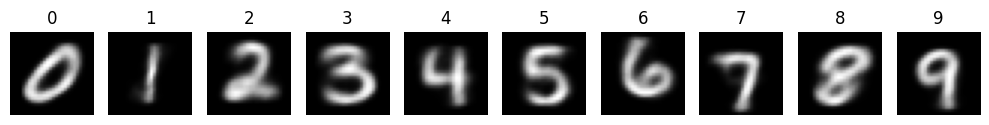

In [185]:
def generate_digits(model: VAE):
    """Генерирует и отображает изображения цифр 0-9."""
    plt.figure(figsize=(10, 2))
    
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        z = tf.random.normal((1, params['z_dim']))
        digit_one_hot = tf.one_hot([i], depth=10)
        res = model.decode(z, digit_one_hot).numpy()
        plt.imshow(res.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(str(i))
    plt.tight_layout()
    plt.show()

generate_digits(model)